<h1>Group 2: Cameroon coin classification</h1>

<p>
    We use CNN to classify the coins as either <span style="color: blue">25F, 50F, 100F or 500F</span>
</p>

In [41]:
import os
import shutil
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np

<h2>
We prepare and preprocess the data
</h2>

<p>
We do this by
</p>

<ol>
<li> Specify the paths to our directories
<li> Prepare the data (which includes dividing it into categories aided by our folder structure)
</ol>

In [2]:
data_dir = '../data/'
train_dir = os.path.join(data_dir, 'training_set')
test_dir = os.path.join(data_dir, 'test_set')

In [3]:
def prepare_data(data_dir, train_dir, test_dir, split_ratio=0.8):
    # Create train and test directories if they do not exist
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)
    
    # Initialize a set to collect all category names
    all_categories = set()

    # Process training_set directory
    training_set_path = os.path.join(data_dir, 'training_set')
    if os.path.isdir(training_set_path):
        categories = os.listdir(training_set_path)
        print(f"Categories found in training_set: {categories}")  # Debugging print

        for category in categories:
            category_path = os.path.join(training_set_path, category)
            print(f"Processing category: {category}")  # Debugging print

            if os.path.isdir(category_path):
                images = os.listdir(category_path)
                print(f"Images found in {category}: {images}")  # Debugging print

                if len(images) == 0:
                    print(f"No images found in category {category}. Skipping...")  # Debugging print
                    continue  # Skip empty categories

                # Add category to the set of all categories
                all_categories.add(category)

                # Perform train-test split
                train_images, test_images = train_test_split(images, test_size=1 - split_ratio)
                print(f"Training images: {train_images}")  # Debugging print
                print(f"Testing images: {test_images}")  # Debugging print

                # Create category directories in train and test directories
                train_category_path = os.path.join(train_dir, category)
                test_category_path = os.path.join(test_dir, category)
                os.makedirs(train_category_path, exist_ok=True)
                os.makedirs(test_category_path, exist_ok=True)

                # Copy training images
                for image in train_images:
                    src = os.path.join(category_path, image)
                    dst = os.path.join(train_category_path, image)
                    if not os.path.exists(dst):
                        shutil.copy(src, dst)

                # Copy testing images
                for image in test_images:
                    src = os.path.join(category_path, image)
                    dst = os.path.join(test_category_path, image)
                    if not os.path.exists(dst):
                        shutil.copy(src, dst)
    else:
        print(f"No directory found for training_set in {data_dir}")

    # Process test_set directory without splitting
    test_set_path = os.path.join(data_dir, 'test_set')
    if os.path.isdir(test_set_path):
        categories = os.listdir(test_set_path)
        print(f"Categories found in test_set: {categories}")  # Debugging print

        for category in categories:
            category_path = os.path.join(test_set_path, category)
            print(f"Processing category: {category}")  # Debugging print

            if os.path.isdir(category_path):
                images = os.listdir(category_path)
                print(f"Images found in {category}: {images}")  # Debugging print

                if len(images) == 0:
                    print(f"No images found in category {category}. Skipping...")  # Debugging print
                    continue  # Skip empty categories

                # Add category to the set of all categories
                all_categories.add(category)

                test_category_path = os.path.join(test_dir, category)
                os.makedirs(test_category_path, exist_ok=True)

                # Copy test images
                for image in images:
                    src = os.path.join(category_path, image)
                    dst = os.path.join(test_category_path, image)
                    if not os.path.exists(dst):
                        shutil.copy(src, dst)
    else:
        print(f"No directory found for test_set in {data_dir}")

    # Print all categories found
    print(f"All categories found: {all_categories}")
    return all_categories

In [4]:
all_categories = prepare_data(data_dir, train_dir, test_dir)

Categories found in training_set: ['100_franc', '25_franc', '500_franc', '50_franc', 'test_set']
Processing category: 100_franc
Images found in 100_franc: ['WhatsApp Image 2024-06-22 at 14.47.43.jpeg', 'WhatsApp Image 2024-06-22 at 15.28.13 (2).jpeg', 'WhatsApp Image 2024-06-22 at 15.28.14.jpeg']
Training images: ['WhatsApp Image 2024-06-22 at 15.28.13 (2).jpeg', 'WhatsApp Image 2024-06-22 at 15.28.14.jpeg']
Testing images: ['WhatsApp Image 2024-06-22 at 14.47.43.jpeg']
Processing category: 25_franc
Images found in 25_franc: ['WhatsApp Image 2024-06-22 at 15.28.14 (3).jpeg', 'WhatsApp Image 2024-06-22 at 15.28.14 (4).jpeg', 'WhatsApp Image 2024-06-22 at 15.28.14 (5).jpeg', 'WhatsApp Image 2024-06-22 at 15.28.14 (6).jpeg']
Training images: ['WhatsApp Image 2024-06-22 at 15.28.14 (3).jpeg', 'WhatsApp Image 2024-06-22 at 15.28.14 (4).jpeg', 'WhatsApp Image 2024-06-22 at 15.28.14 (5).jpeg']
Testing images: ['WhatsApp Image 2024-06-22 at 15.28.14 (6).jpeg']
Processing category: 500_franc
Im

<h2>Training convolutional neural networ</h2>
<p> In this section we set the parameters, define and train our CNN

In [26]:
batch_size = 32
img_height = 64  # Updated image height
img_width = 64   # Updated image width

In [27]:
# Get the number of classes from the prepared data
num_classes = len(all_categories)
categories_list = list(all_categories)

# Prepare the data generators
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [28]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    classes=categories_list)

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    classes=categories_list)

Found 13 images belonging to 4 classes.
Found 13 images belonging to 4 classes.


In [29]:
model = models.Sequential([
    layers.InputLayer(input_shape=(img_height, img_width, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),  # Ensure the output is flattened before passing to Dense layers
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [30]:
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=10
)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.3846 - loss: 1.3649 - val_accuracy: 0.3077 - val_loss: 1.4265
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.3077 - loss: 1.4265 - val_accuracy: 0.3077 - val_loss: 1.3173
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.3077 - loss: 1.3173 - val_accuracy: 0.3846 - val_loss: 1.3156
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.3846 - loss: 1.3156 - val_accuracy: 0.6923 - val_loss: 1.2972
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.6923 - loss: 1.2972 - val_accuracy: 0.3077 - val_loss: 1.2757
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.3077 - loss: 1.2757 - val_accuracy: 0.3077 - val_loss: 1.2479
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.3077 - loss: 1.2479 - val_accuracy: 0.6154 - val_loss: 1.2181
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - accuracy: 0.6154 - loss: 1.2181 - val_accuracy: 0.5385 - val_loss: 1.

<h1>
Testing the model
</h1>
<p> Here we test our model, save it, then finally we perform an actual classification with an image

In [32]:
test_loss, test_acc = model.evaluate(validation_generator)
print(f'Test accuracy: {test_acc}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.6154 - loss: 1.0977
Test accuracy: 0.6153846383094788


In [33]:
model.save('../models/coin_classifier.h5')

In [34]:
model = tf.keras.models.load_model('../models/coin_classifier.h5')

In [37]:
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize to [0, 1]
    return img_array

In [38]:
def classify_image(img_path, model, categories_list):
    img_array = load_and_preprocess_image(img_path)
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]
    confidence = predictions[0][predicted_class]
    predicted_label = categories_list[predicted_class]
    return predicted_label, confidence

In [43]:
img_path = r'..\data\test_set\25_franc\WhatsApp Image 2024-06-22 at 15.28.14 (3).jpeg'

In [44]:
predicted_label, confidence = classify_image(img_path, model, categories_list)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


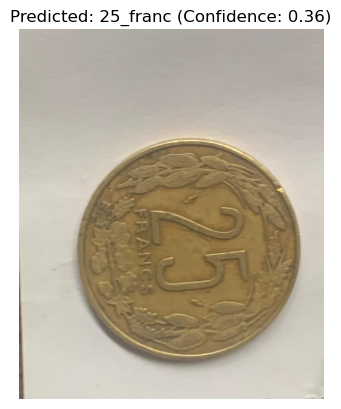

Predicted label: 25_franc with confidence: 0.36


In [45]:
# Display the image and the classification result
img = image.load_img(img_path)
plt.imshow(img)
plt.title(f'Predicted: {predicted_label} (Confidence: {confidence:.2f})')
plt.axis('off')
plt.show()

print(f'Predicted label: {predicted_label} with confidence: {confidence:.2f}')